# Prerequisites
- Lattices

# Theory

- https://youtu.be/SZkTJMorxnM?t=279 - simple explanation

## LWE

*Idea*:
- Find secret $s \in \mathbb{Z}^n_q$ given many *noisy inner products*

### Search LWE

**Definition**

Given the following parameters $n, q = poly(n)$, gaussian error distribution $\chi \in \mathbb{Z}_q$ => We define the problem Search-$LWE_{n, m, q, \chi}$ as follows:

> Given $m$ independent samples $(\vec{a_i}, b_i) \in \mathbb{Z}_q^n \times \mathbb{Z}_q$ generated as follows
>
>$\begin{equation}
\vec{a_1} \leftarrow \mathbb{Z}_q^n , \ \ b_1 = \langle s, \vec{a_1} \rangle + e_1\\
\vec{a_2} \leftarrow \mathbb{Z}_q^n , \ \ b_2 = \langle s, \vec{a_2} \rangle + e_2\\
\vdots
\end{equation}$
>
> - for some errors $e_i \leftarrow \chi$ with width $\alpha q > \sqrt n$
>
> find $s \in \mathbb{Z}_q^n$

Matrix notation:

$$A = \begin{bmatrix}
| & &  | \\
a_1 & \dots & a_m  \\
| & &  | \\
\end{bmatrix}, \ \ b^T = s^TA + e^T$$

Drawing:
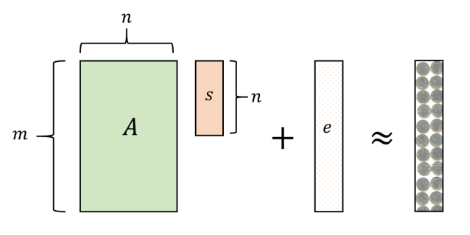

**Notes**
- Without $e_i$ we can efficiently recover $s$ with Gaussian elimination

### Decision LWE

**Definition**
> Distinguish $(A, b^T = s^TA + e^T)$ from uniform $(A, b^T)$ where $A = (a_1, ... a_m)$

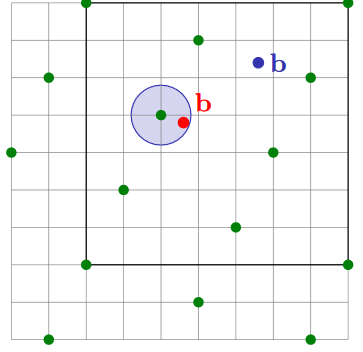


## Lattice

Let $\mathcal{L}(A) = \{z \in \mathbb{Z}^m z^t = s^tA \bmod q \}$ be the LWE lattice
- $\mathcal{L}(A) = q(\mathcal{L}^\perp(A))^\vee$ = scaled dual of SIS lattice

**BDD problem on $\mathcal{L}(A)$**

Given $b^T \approx v^T = s^TA \in \mathcal{L}(A)$, find $v$
- The ammount of error is very small to the minimum distance 

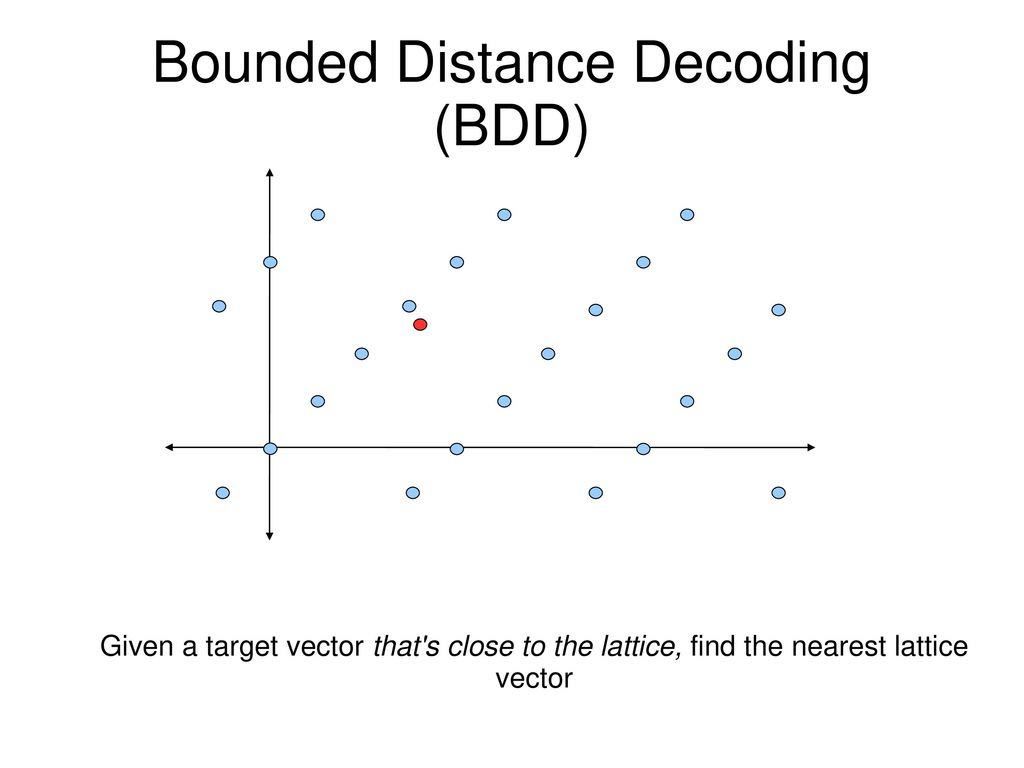

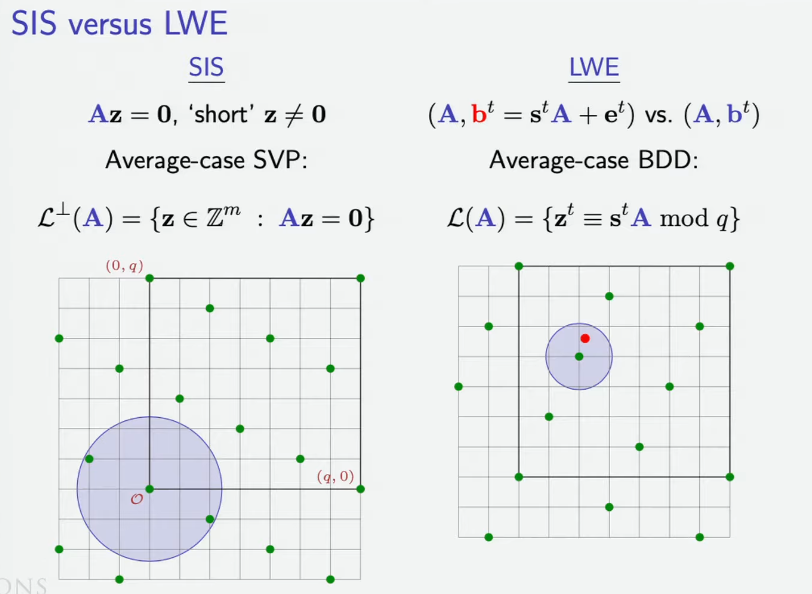

## Properties

**Easy to check if a solution is small**
- test $b - \langle s', a \rangle$ is small

**Shift the secret by any $t \in \mathbb{Z}^n_q$**
- $(a, b = \langle s, a \rangle + e) \to (a, b' = b + \langle t, a \rangle = \langle s + t, a \rangle + e)$

## Cryptosystems

### Public key (encrypting a bit)

#### Regev

Public parameters: $A \in \mathbb{Z}_q^{n\times m}$

**Alice** 
- chooses a secret $s \in \mathbb{Z}_q^n$
- generates public key $b^T = s^TA + e^T$

**Bob**
- chooses a secret $x \in \{0, 1\}^m$
- computes and sends to Alice
    - $u = Ax$ - the hash of the secret
    - $u' = b^Tx + bit \cdot \dfrac q 2$
    
**Alice**
- decodes $u' - s^Tu \approx bit \cdot \dfrac q 2$

**Note**
- $(A, b^t)$ is $LWE$
- $(u, u')$ are uniformly random by left-over hash lemma when $m \geq nlog_2 q$

#### Dual 

Public parameters: $A \in \mathbb{Z}_q^{n\times m}$

**Alice** 
- chooses a secret $x \in \{0, 1\}^m$
- sends to Bob her **public key**
    - $u = Ax$ - the hash of the secret


**Bob**
- chooses a secret $s \in \mathbb{Z}_q^n$
- generates and sends to Alice
    - $b^T = s^TA + e^T$
    - $b' = s^Tu + e' + bit \cdot \dfrac q 2$ - adding $bit \cdot \dfrac q 2$ does not break the uniformity of $s^TA + e^T$

**Alice**
- decodes $b' - b^Tx \approx bit \cdot \dfrac q 2$
- $b' - b^Tx = s^Tu + e' + bit \cdot \dfrac q 2 - (s^TA + e^T)x = \underbrace{s^Tu - s^T\underbrace{Ax}_{u}}_{=0} + \underbrace{\overbrace{e^Tx}^{\text{both small}} - e'}_{\text{very small} << q/2} +  bit \cdot \dfrac q 2 \approx bit \cdot \dfrac q 2$

**Note**
- $(A,u; b, b')$ is $LWE$ pair

# Code

## Dual

In [301]:
import random
from sage.stats.distributions.discrete_gaussian_lattice import DiscreteGaussianDistributionLatticeSampler
from sage.stats.distributions.discrete_gaussian_integer import DiscreteGaussianDistributionIntegerSampler

In [1]:
is_prime(127)

True

In [216]:
#Public parameters
q = next_prime(400)
n = 10
m = n * ceil(log(q, 2)) + 1
A = random_matrix(Zmod(q), m, n)


In [279]:
#Alice1
def generate_keys(A, m, n, q):
    x = vector(Zmod(q), [random.randint(0, 1) for i in range(m)]) #Alice's secret
    u = x * A # Alice's public key
    return x, u

x, u = generate_keys(A, m, n, q)
print(x)
print(u)

(0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1)
(119, 69, 349, 66, 281, 213, 164, 120, 363, 226)


In [315]:
#Bob1
def encrypt_bit(bit, u, A, m, n, q):
    s = vector(Zmod(q), [round(random.randint(0, q-1)) for i in range(n)]) #Bob's secret
    #generate errors
    #e = vector(Zmod(q), [round(random.gauss(0, sqrt(n) + 1)) for _ in range(m)]) # lol this
    Dl = DiscreteGaussianDistributionLatticeSampler(Zmod(q)**m, sqrt(n)+1)
    e = Dl()
    #e_ = round(random.gauss(0, sqrt(n) + 1)) #lol this 2
    D = DiscreteGaussianDistributionIntegerSampler(sigma = sqrt(n)+1)
    e_ = Zmod(q)(D())
    
    b = A * s + e
    b_ = u * s + e_ + bit * q // 2
    return b, b_

bit = 1
b, b_ = encrypt_bit(bit, u, A, m, n, q)

In [316]:
print(b)
print(b_)

(252, 240, 193, 396, 31, 370, 171, 46, 291, 258, 134, 104, 73, 231, 118, 315, 19, 262, 195, 116, 100, 192, 349, 70, 243, 139, 232, 304, 365, 222, 58, 28, 172, 31, 8, 69, 92, 357, 239, 397, 226, 24, 33, 9, 112, 263, 40, 84, 231, 74, 292, 132, 374, 285, 2, 178, 241, 380, 184, 213, 199, 132, 313, 253, 347, 345, 287, 188, 342, 349, 308, 175, 47, 119, 272, 380, 357, 51, 400, 145, 102, 331, 86, 86, 251, 72, 188, 124, 4, 185, 362)
93


In [317]:
#Alice2
print(b_ - b * x)
print(bit, int(q//4 <=  b_ - b * x  < 3 * q//4 )) # check if it's closer to q//2 to receive the bit

192
1 1


## Defined constructions in Sage

https://doc.sagemath.org/html/en/reference/cryptography/sage/crypto/lwe.html

In [178]:
from sage.stats.distributions.discrete_gaussian_integer import DiscreteGaussianDistributionIntegerSampler

In [179]:
D = DiscreteGaussianDistributionIntegerSampler(sigma = 3)

In [206]:
vector(Zmod(q), [D() for _ in range(m)])

(4, 125, 0, 5, 126, 3, 125, 125, 126, 0, 3, 124, 124, 121, 3, 4, 0, 124, 1, 2, 122, 4, 126, 1, 4, 3, 2, 0, 125, 124, 2, 2, 124, 126, 0, 0, 7, 124, 0, 0, 126, 3, 1, 1, 5, 122, 125, 0, 6, 123, 122, 2, 125, 1, 1, 4, 123, 1, 126, 1, 4, 125, 6, 5, 3, 1, 2, 124, 125, 124, 4)

In [286]:
from sage.stats.distributions.discrete_gaussian_lattice import DiscreteGaussianDistributionLatticeSampler

In [304]:
Dl = DiscreteGaussianDistributionLatticeSampler(Zmod(q)**n, sqrt(n)+1)

In [305]:
Dl()

(395, 2, 0, 5, 4, 398, 4, 4, 400, 400)

# Resources

- https://en.wikipedia.org/wiki/Learning_with_errors
- http://cryptowiki.net/index.php?title=LWE-based_cryptographic_protocols
- https://eprint.iacr.org/2015/938.pdf - page 10
- https://cims.nyu.edu/~regev/papers/lwesurvey.pdf - regev paper
- https://asecuritysite.com//encryption/lwe_output
- https://www.youtube.com/watch?v=K_fNK04yG4o&list=PLgKuh-lKre10rqiTYqJi6P4UlBRMQtPn0&index=5

- https://crypto.stackexchange.com/questions/26169/how-to-generate-new-lwe-samples - generating more samples from a given set